# Report Generation

In [18]:
# run in base directory
WORKDIR = "/home/awesome"
import os
os.chdir(WORKDIR)

# datatypes
import json
import yaml
from datetime import datetime
# database connection
import psycopg2
import psycopg2.extras
import psycopg2.extensions as psql_ext
from psycopg2 import sql
# computation
import pandas as pd
# utilities
from pathlib import Path
import itertools
# typing
from typing import Union
# visualization
import plotly.graph_objs as go
from plotly.subplots import make_subplots

PROJECT_SCHEMA = 'citibike_project'

WORKDIR_PATH = Path.cwd()
REPORTING_PATH = WORKDIR_PATH / 'reporting'

In [4]:
# PSQL db connection using psycopg2
conn = psycopg2.connect(
    dbname='new_db', 
    user='awesome_user', 
    password='awesome_password', 
    host='postgres', 
    port='5432'
)

## Assemble Visuals

### Vis 1: Historic rides, precip by day

In [30]:
query_rides_by_day = f"""
    WITH

    rides AS (
        SELECT
            sh.year,
            sh.month,
            sh.day,
            SUM(num_inbound) AS n_rides
        FROM
            {PROJECT_SCHEMA}.citibike_station_history sh
        GROUP BY 1, 2, 3
    ),

    weather AS (
        SELECT
            EXTRACT(YEAR FROM wp.date) AS year,
            EXTRACT(MONTH FROM wp.date) AS month,
            EXTRACT(DAY FROM wp.date) AS day,
            SUM(CAST(wp.one_hour_precip_amount AS FLOAT)) AS precip_amount
        FROM
            {PROJECT_SCHEMA}.weather_precip wp
        GROUP BY 1, 2, 3
    )

    SELECT
        r.*,
        w.precip_amount
    FROM
        rides r
        LEFT JOIN weather w
            ON r.year = w.year AND r.month = w.month AND r.day = w.day
"""

df_rides_by_day = pd.read_sql_query(query_rides_by_day, conn)
df_rides_by_day["dt"] = df_rides_by_day.apply(
    lambda row: datetime(row.year, row.month, row.day), axis=1
)

/tmp/ipykernel_93/3113264167.py:35: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [ ]:


df_precip_by_day = pd.read_sql_query(query_rides_by_day, conn)
df_rides_by_day["dt"] = df_rides_by_day.apply(
    lambda row: datetime(row.year, row.month, row.day), axis=1
)

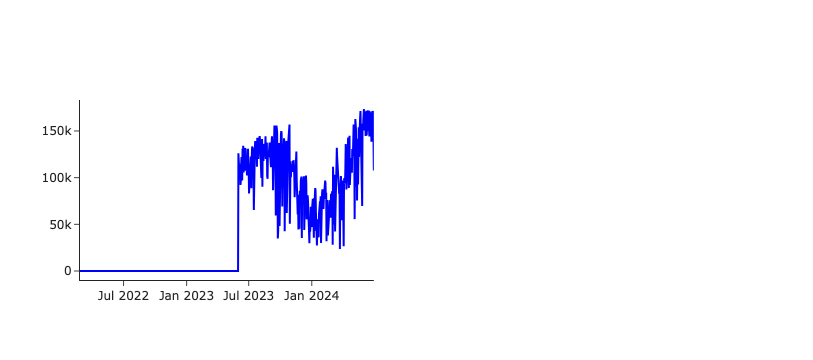

In [25]:
fig_rides_by_day = make_subplots(rows=1, cols = 2)

fig_rides_by_day.add_trace(
    go.Scatter(
        x=df_rides_by_day['dt'],
        y=df_rides_by_day['n_rides'],
        marker={"color":"blue"},
        mode="lines"
        # width=1,
    ),
    row=1, col=1
)

fig_rides_by_day.add_trace(
    go.Scatter(
        x=df_rides_by_day['dt'],
        y=df_rides_by_day['n_rides'],
        marker={"color":"blue"},
        mode="lines"
        # width=1,
    ),
    row=1, col=1
)

fig_rides_by_day.update_layout(
    template="simple_white"
)

fig_rides_by_day.show()

<Axes: xlabel='dt'>

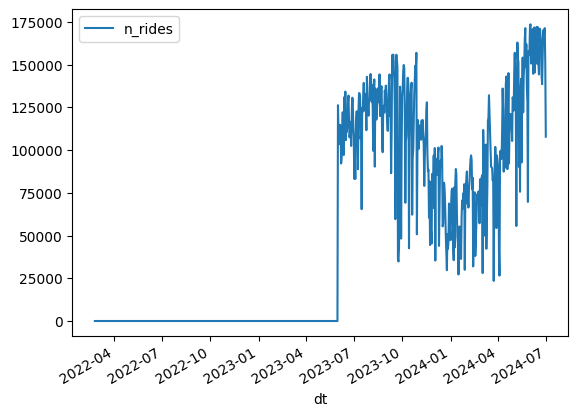

In [12]:

ssdf_rides_by_day.set_index("dt")[["n_rides"]].plot()

### Vis 2: Weather By Day

In [ ]:
df_stations = pd.read_sql_query(f"SELECT * FROM {PROJECT_SCHEMA}.station_info", conn)
df_largest_stations = df_stations.sort_values(by="capacity", ascending=False).iloc[:50]

In [ ]:
df_weather_precip = pd.read_sql_query(f"SELECT * FROM {PROJECT_SCHEMA}.weather_precip", conn)
df_weather_precip["one_hour_precip_amount"] = pd.to_numeric(df_weather_precip['one_hour_precip_amount'], errors='coerce')
df_weather_precip_daily = df_weather_precip.groupby(by="date")[["one_hour_precip_amount"]].sum()

In [ ]:


df_stations = pd.read_sql_query(f"SELECT * FROM {PROJECT_SCHEMA}.station_info", conn)

df_weather_precip = pd.read_sql_query(f"SELECT * FROM {PROJECT_SCHEMA}.weather_precip", conn)
df_weather_precip["one_hour_precip_amount"] = pd.to_numeric(df_weather_precip['one_hour_precip_amount'], errors='coerce')
df_weather_precip_daily = df_weather_precip.groupby(by="date")[["one_hour_precip_amount"]].sum()

# Create simple plots
bar1 = go.Bar(x=df_weather_precip_daily.index, y=df_weather_precip_daily.one_hour_precip_amount)
layout1 = go.Layout()
fig1 = go.Figure([bar1], layout1)

# Create another simple plot
# Create a table
fig2 = go.Figure(data=[go.Table(
    header=dict(
        values=list(df_largest_stations.to_dict().keys()),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=df_largest_stations.values.T,
        fill_color='lavender',
        align='left'
    ))
])

# Convert figures to HTML strings
fig1_html = fig1.to_html(full_html=False, include_plotlyjs='cdn')
fig2_html = fig2.to_html(full_html=False, include_plotlyjs='cdn')

# Create the HTML template
template = """
<html>

df_largest_stations = df_stations.sort_values(by="capacity", ascending=False).iloc[:50]
<head>
    <title>Plotly Report</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <h1>CitiBike Report</h1>
    <div id='divPlotly1'>
        <h2>Daily Precipitation</h2>
        {fig1_html}
    </div>
    <div id='divPlotly2'>
        <h2>Largest Stations</h2>
        {fig2_html}
    </div>
</body>
</html>
"""

# Write the HTML report to a file
with open('report.html', 'w') as f:
    f.write(template.format(fig1_html=fig1_html, fig2_html=fig2_html))
